In [1]:
import pandas as pd
import numpy as np
import cupy as cp  # CuPy for GPU arrays 
import matplotlib.pyplot as plt
import os

# from rdkit import Chem
# from rdkit.Chem import Descriptors
# from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

from sklearn.multioutput import MultiOutputRegressor  # This “wraps” one XGBoost regressor per target dimension. Each hot‐encoded solvent ratio column becomes a separate sub‐model internally.

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.plotting

In [2]:
# Parity plotter 
# ===========================================================================================
def plot_parity_with_metrics(target_name, data, metrics, save_path=None):
    """
    Creates a parity (observed vs. predicted) plot for train and test sets,
    annotated with MSE and R² metrics.
    """
    observed_train = data["train_observed"]
    predicted_train = data["train_predicted"]
    observed_test = data["test_observed"]
    predicted_test = data["test_predicted"]

    train_mse = metrics["train_mse"]
    test_mse = metrics["test_mse"]
    test_r2 = metrics["test_r2"]

    plt.figure(figsize=(8, 6))
    plt.scatter(observed_train, predicted_train, label="Train", color="blue", alpha=0.6)
    plt.scatter(observed_test, predicted_test, label="Test", color="red", alpha=0.6)

    # Plot perfect-fit line
    min_val = min(observed_train.min(), observed_test.min())
    max_val = max(observed_train.max(), observed_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black", label="Perfect Fit")

    # Text box with metrics
    metrics_text = (
        f"Train MSE: {train_mse:.2f}\n"
        f"Test MSE: {test_mse:.2f}\n"
        f"Test R²: {test_r2:.2f}"
    )
    plt.text(
        0.05, 0.95, metrics_text,
        transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    plt.xlabel(f"Observed {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Parity Plot for {target_name}")
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=1200)
    plt.close()
    

In [3]:
# ============================================================================
# Note that this a new excel sheet I generated 
# from the preprocessing script that is read in.
# ============================================================================


polystyrene_path = r"C:\Users\Dillo\OneDrive\Documents\GitHub\LCCC-ML\polystyrene-imputated-solvents-hot-encoded-2-23-25.xlsx"
polystyrene       = pd.read_excel(polystyrene_path)

In [4]:
polystyrene

,Hexane,Tetrahydrofuran,Dichloromethane,Acetonitrile,Tetrachloromethane,Ethyl Acetate,Toluene,Carbon Dioxide,Xylene,Cyclohexane,...,Stationary Phase_YMC RP,Stationary Phase_YMC-ODSA,Stationary Phase_μBondapak NH2,Stationary Phase_μStyragel HT,Base Material_PS/DVB,Base Material_Silica,Base Material Modification_NH2,Base Material Modification_No Modifications,Base Material Modification_Unknown,Phase_Reverse
0,53.0,47.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,1,0,0
1,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,1,0,0
2,56.6,43.4,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,0,0,1
3,0.0,0.0,57.0,43.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,0,0,1
4,0.0,0.0,35.0,65.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,0.0,0.0,57.0,43.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,0,0,1
168,51.5,49.5,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,1,0,0
169,0.0,0.0,57.0,43.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,0,0,1
170,57.0,43.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
# Predict the 1D target "Solvent Ratio_1"  -- this only works for two pairs of solvents
solvent_ratio = polystyrene[[
    'Hexane', 'Tetrahydrofuran', 'Dichloromethane', 'Acetonitrile',
    'Tetrachloromethane', 'Ethyl Acetate', 'Toluene', 'Carbon Dioxide',
    'Xylene', 'Cyclohexane', 'Dimethylacetamide', 'Heptane', 'Decalin',
    'Dimethylformamide', 'Water', 'Chloroform', 'Methanol',
    '2,2,4-Trimethylpentane', 'Methyl Ethyl Ketone', 'Cyclohexanone'
]].values # target: 1D array


meta_data_cols = [
    'Hexane', 'Tetrahydrofuran', 'Dichloromethane', 'Acetonitrile',
    'Tetrachloromethane', 'Ethyl Acetate', 'Toluene', 'Carbon Dioxide',
    'Xylene', 'Cyclohexane', 'Dimethylacetamide', 'Heptane', 'Decalin',
    'Dimethylformamide', 'Water', 'Chloroform', 'Methanol',
    '2,2,4-Trimethylpentane', 'Methyl Ethyl Ketone', 'Cyclohexanone'
]

In [6]:
# Drop columns that are not features (e.g., Polymer and solvents used for meta)
columns_to_drop = [
    "Polymer"
] + meta_data_cols  # drop polymer name and the 20 solvent columns

feature_columns  = polystyrene.drop(columns=columns_to_drop).columns

X = polystyrene.drop(columns=columns_to_drop).values
y = solvent_ratio

In [7]:
print("Feature matrix X shape:", X.shape)
print("Target y shape:", y.shape)

Feature matrix X shape: (172, 173)
Target y shape: (172, 20)


In [8]:
# ============================================================================
# Split the data (80% train, 10% validation, 10% test)
# ============================================================================

# Split into train and temporary sets while returning row indices
X_train_np, X_temp_np, y_train_np, y_temp_np, idx_train, idx_temp = train_test_split(
    X, y, np.arange(len(X)), test_size=0.20, random_state=42
)
X_val_np, X_test_np, y_val_np, y_test_np, idx_val, idx_test = train_test_split(
    X_temp_np, y_temp_np, idx_temp, test_size=0.5, random_state=42
)

In [9]:
print(f"Train size: {X_train_np.shape[0]}")
print(f"Validation size: {X_val_np.shape[0]}")
print(f"Test size: {X_test_np.shape[0]}")

Train size: 137
Validation size: 17
Test size: 18


In [10]:
# ============================================================================
# Convert arrays to CuPy arrays for GPU training
# Note: With only ~200 samples, GPU training probably not be necessary.
# ============================================================================

X_train = cp.asarray(X_train_np)
y_train = cp.asarray(y_train_np)
X_val   = cp.asarray(X_val_np)
y_val   = cp.asarray(y_val_np)
X_test  = cp.asarray(X_test_np)
y_test  = cp.asarray(y_test_np)

In [11]:
def multioutput_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

multi_mse_scorer = make_scorer(
    multioutput_mse,
    greater_is_better=False  # so that cross_val_score returns negative MSE
)

In [12]:
# ============================================================================
# Define the hyperparameter tuning objective function (Hyperopt)
# ============================================================================

def objective(params):
    # Convert integer parameters to int type
    params['n_estimators']           = int(params['n_estimators'])
    params['max_depth']              = int(params['max_depth'])
    params['learning_rate']          = float(params['learning_rate'])
    params['gamma']                  = float(params['gamma'])
    params['min_child_weight']       = int(params['min_child_weight'])
    params['subsample']              = float(params['subsample'])
    params['colsample_bytree']       = float(params['colsample_bytree'])
    # params['colsample_bylevel']      = float(params['colsample_bylevel'])
    # params['colsample_bynode']       = float(params['colsample_bynode'])
    params['reg_alpha']              = float(params['reg_alpha'])
    params['reg_lambda']             = float(params['reg_lambda'])
    
    params['max_bin']                = int(params['max_bin'])
    params['max_cat_threshold']      = int(params['max_cat_threshold'])
    
    # Force GPU usage in XGBoost 2.1.4 -- my current version
    params['tree_method']            = 'hist'
    params['device']                 = 'cuda'
    
    
    ### We may want to look into setting some monotonic constraints
    ### Or maybe even the more complicated interation_constraints
    ### or the max_cat_to_onehot param ---- can help interpretability 
    
    #############################################################################
    # Create and train the model on GPU arrays
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        # early_stopping_rounds=10,  # won't work with MultiOutputRegressor
        **params
    )
    
    # Wrap in MultiOutputRegressor
    multi_model = MultiOutputRegressor(xgb_reg)
    
    # We'll do 5-fold CV on the training split (CPU arrays).
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    
    # cross_val_score returns negative MSE (due to make_scorer above)
    cv_scores = cross_val_score(
        multi_model,
        X_train_np,         # CPU arrays for CV
        y_train_np,         # CPU arrays for CV
        cv=kf,
        scoring=multi_mse_scorer
    )
    
        # Convert from negative MSE to positive MSE
    mse_scores = -cv_scores
    avg_mse = np.mean(mse_scores)
    
    return {'loss': avg_mse, 'status': STATUS_OK}

In [13]:
    
    # multi_model.fit(
    #     X_train, y_train,
    #     eval_set=[(X_val, y_val)],
    #     verbose=False
    # )
    
    # # Predict on the validation set
    # y_pred_cp = multi_model.predict(X_val)
    
    # # Convert predictions and validation targets back to NumPy arrays
    # y_pred_np = cp.asnumpy(y_pred_cp)
    # y_val_np = cp.asnumpy(y_val)
    
    # mse = mean_squared_error(y_val_np, y_pred_np)
    # return {'loss': mse, 'status': STATUS_OK}

In [14]:
# Define the search space for hyperparameters
search_space = {
    'n_estimators':       hp.quniform('n_estimators', 50, 500, 10),
    'max_depth':          hp.quniform('max_depth', 3, 5, 1),
    'learning_rate':      hp.loguniform('learning_rate', -4, -1),
    'subsample':          hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree':   hp.uniform('colsample_bytree', 0.5, 1.0),
    # 'colsample_bylevel':  hp.uniform('colsample_bylevel', 0.5, 1.0),  # 50% to 100% per level
    # 'colsample_bynode':   hp.uniform('colsample_bynode', 0.5, 1.0),
    'reg_alpha':          hp.loguniform('reg_alpha', -5, 2),
    'reg_lambda':         hp.loguniform('reg_lambda', -5, 2),
    'gamma':              hp.uniform('gamma', 0, 7),
    'min_child_weight':   hp.quniform('min_child_weight', 1, 5, 1),
    'max_bin':            hp.quniform('max_bin', 128, 1024, 16),
    'max_cat_threshold':  hp.quniform('max_cat_threshold', 16, 1024, 16)
}

In [15]:
# Run Hyperopt to tune hyperparameters
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=200,
    trials=trials
)
# Convert certain hyperopt parameters to int
best_params['n_estimators']           = int(best_params['n_estimators'])
best_params['max_depth']              = int(best_params['max_depth'])
best_params['learning_rate']          = float(best_params['learning_rate'])
best_params['gamma']                  = float(best_params['gamma'])
best_params['min_child_weight']       = int(best_params['min_child_weight'])
best_params['subsample']              = float(best_params['subsample'])
best_params['colsample_bytree']       = float(best_params['colsample_bytree'])
# best_params['colsample_bylevel']      = float(best_params['colsample_bylevel'])
# best_params['colsample_bynode']       = float(best_params['colsample_bynode'])
best_params['reg_alpha']              = float(best_params['reg_alpha'])
best_params['reg_lambda']             = float(best_params['reg_lambda'])

# Force GPU usage in XGBoost 2.1.4 -- my current version
best_params['tree_method']            = 'hist'
best_params['device']                 = 'cuda'
best_params['max_bin']                = int(best_params['max_bin'])
best_params['max_cat_threshold']      = int(best_params['max_cat_threshold'])
best_params["objective"]              = "reg:squarederror"
# best_params['early_stopping_rounds'] = 10  # Not used in multi‐output

print("Best Hyperparameters:", best_params)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

c:\Users\Dillo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



100%|██████████| 200/200 [1:13:44<00:00, 22.12s/trial, best loss: 20.913736122080316]
Best Hyperparameters: {'colsample_bytree': 0.5003717050749288, 'gamma': 3.87242657347269, 'learning_rate': 0.056991881872967, 'max_bin': 208, 'max_cat_threshold': 592, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 3.8598042579532015, 'reg_lambda': 3.838613214255723, 'subsample': 0.8643330639372693, 'tree_method': 'hist', 'device': 'cuda', 'objective': 'reg:squarederror'}


In [16]:
# ============================================================================
# Evaluate using 5-fold cross-validation on CPU arrays
# This avoids issues with scikit-learn CV and GPU arrays.
# ============================================================================

# Create a model using the best hyperparameters (for CV, use CPU arrays)
xgb_cv_model = xgb.XGBRegressor(**best_params)
multi_cv_model = MultiOutputRegressor(xgb_cv_model)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    multi_cv_model,
    X_train_np, y_train_np,
    cv=kf,
    scoring=multi_mse_scorer
)

mse_scores = -cv_scores

print("5-Fold CV MSEs:", mse_scores)
print("Mean CV MSE:", mse_scores.mean())



5-Fold CV MSEs: [16.519685   20.01286664 15.53012133 23.46337873 29.0426289 ]
Mean CV MSE: 20.913736122080316


In [17]:
# multi_r2_scorer = make_scorer(
# r2_score(y_true, y_pred, multioutput='uniform_average')
# )

# # Use the CPU arrays (X_train_np, y_train_np) for CV
# # cross_val_score returns an array of 5 scores
# cv_scores = cross_val_score(model_cv, X_train_np, y_train_np, 
#                             cv=kf, scoring=multi_r2_scorer)

# # Because 'multi_mse_scorer' is negative MSE, you can invert it or just 
# # keep in mind that more positive is better:
# cv_scores_positive = -cv_scores  # MSEs for each fold

# print("5-Fold CV MSE scores across all outputs:", cv_scores_positive)
# print("Mean CV MSE:", cv_scores_positive.mean())

In [20]:
# Usually, you'd combine train + val for your final training if you trust your hyperparams
X_final_train_np = np.concatenate([X_train_np, X_val_np], axis=0)
y_final_train_np = np.concatenate([y_train_np, y_val_np], axis=0)

# Convert to CuPy for final GPU training if desired
X_final_train_cp = cp.asarray(X_final_train_np)
y_final_train_cp = cp.asarray(y_final_train_np)

final_model = MultiOutputRegressor(
    xgb.XGBRegressor(**best_params)
)

X_final_train_np = cp.asnumpy(X_final_train_cp)
y_final_train_np = cp.asnumpy(y_final_train_cp)
# Fit the multi‐output model on GPU arrays
final_model.fit(X_final_train_np, y_final_train_np)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5003717050749288,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.87242657347269,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.056991881872967,
                                            max_bin=208, max_cat_threshold=592,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [21]:
y_test_np_conv = cp.asnumpy(y_test)  # shape = (N_test, 20)
y_pred_test = final_model.predict(X_test)  # shape = (N_test, 20)
y_pred_test_np = cp.asnumpy(y_pred_test)

test_mse = mean_squared_error(y_test_np_conv, y_pred_test_np)
test_r2  = r2_score(y_test_np_conv, y_pred_test_np, multioutput='uniform_average')
print(f"Final Test MSE (multi‐output): {test_mse:.4f}")
print(f"Final Test R²  (multi‐output): {test_r2:.4f}")

Final Test MSE (multi‐output): 111.5024
Final Test R²  (multi‐output): -1.0093


In [22]:
# ============================================================================
# Train the final model on GPU arrays with the tuned parameters
# ============================================================================

# final_model = MultiOutputRegressor(
#     xgb.XGBRegressor(**best_params)
# )

# final_model.fit(
#     X_train, y_train,
#     eval_set=[(X_val, y_val)],
#     verbose=0
# )

# # Evaluate the final model on the test set
# y_train_np_conv = cp.asnumpy(y_train)
# y_test_np_conv  = cp.asnumpy(y_test)

# # Train predictions
# y_pred_train_cp = final_model.predict(X_train)
# y_pred_train_np = cp.asnumpy(y_pred_train_cp)

# # Test predictions
# y_pred_test = final_model.predict(X_test)
# y_pred_test_np = cp.asnumpy(y_pred_test)
# y_test_np_conv = cp.asnumpy(y_test)



# train_mse = mean_squared_error(y_train_np_conv, y_pred_train_np)
# test_mse  = mean_squared_error(y_test_np_conv, y_pred_test_np)
# test_r2   = r2_score(y_test_np_conv, y_pred_test_np)

parity_data = {
    #"train_observed":   y_train_np_conv,
    #"train_predicted":  y_pred_train_np,
    "test_observed":    y_test_np_conv,
    "test_predicted":   y_pred_test_np
}
parity_metrics = {
    #"train_mse": train_mse,
    "test_mse":  test_mse,
    "test_r2":   test_r2
}

print(f"Test MSE across all outputs: {test_mse:.4f}")
print(f"Test R² across all outputs:  {test_r2:.4f}")

Test MSE across all outputs: 111.5024
Test R² across all outputs:  -1.0093


In [ ]:
# If you see negative R² for the averaged or per-output metric (e.g., R² = -1.00), it indicates the model is performing worse than a naive baseline that always predicts the mean.
# High MSE or negative R² means either the problem is quite difficult, or the model/hyperparameters might need refinement.
# Breaking down the MSE/R² by column helps identify which solvent columns are being predicted well vs. poorly.

In [32]:
test_mse_raw = mean_squared_error(
    y_test_np, 
    y_pred_test_np, 
    multioutput="raw_values"  # 1D array of shape (n_outputs,)
)
test_r2_raw = r2_score(
    y_test_np, 
    y_pred_test_np, 
    multioutput="raw_values"   # 1D array of shape (n_outputs,)
)

print("Per-Output MSE:", test_mse_raw)  # array of length = number_of_outputs
print("Per-Output R²: ", test_r2_raw)

Per-Output MSE: [7.55977354e+00 2.08286194e+02 1.12830677e+00 4.06927429e+01
 1.15150286e+02 2.63134294e+01 2.45844791e+02 4.04453737e-01
 5.74232526e+01 4.64088538e+02 3.64500000e+02 5.30583872e+00
 5.10933889e+02 1.13039417e+02 3.94640396e-01 9.93615099e-03
 2.84014727e-04 6.80027866e+01 3.53619493e-02 9.33888889e-01]
Per-Output R²:  [  0.98799104   0.77353818   0.99744093   0.90432055   0.
   0.64994058   0.           0.99859565   0.         -26.29932578
  -0.05882353   0.          -0.05882353   0.           0.97700103
   0.           0.           0.           0.          -0.05882353]


In [34]:
for i, col_name in enumerate(meta_data_cols):
    print(f"{col_name:25s} | MSE={test_mse_raw[i]:.4f}, R²={test_r2_raw[i]:.4f}")

Hexane                    | MSE=7.5598, R²=0.9880
Tetrahydrofuran           | MSE=208.2862, R²=0.7735
Dichloromethane           | MSE=1.1283, R²=0.9974
Acetonitrile              | MSE=40.6927, R²=0.9043
Tetrachloromethane        | MSE=115.1503, R²=0.0000
Ethyl Acetate             | MSE=26.3134, R²=0.6499
Toluene                   | MSE=245.8448, R²=0.0000
Carbon Dioxide            | MSE=0.4045, R²=0.9986
Xylene                    | MSE=57.4233, R²=0.0000
Cyclohexane               | MSE=464.0885, R²=-26.2993
Dimethylacetamide         | MSE=364.5000, R²=-0.0588
Heptane                   | MSE=5.3058, R²=0.0000
Decalin                   | MSE=510.9339, R²=-0.0588
Dimethylformamide         | MSE=113.0394, R²=0.0000
Water                     | MSE=0.3946, R²=0.9770
Chloroform                | MSE=0.0099, R²=0.0000
Methanol                  | MSE=0.0003, R²=0.0000
2,2,4-Trimethylpentane    | MSE=68.0028, R²=0.0000
Methyl Ethyl Ketone       | MSE=0.0354, R²=0.0000
Cyclohexanone             | 

In [37]:
for col_idx, col_name in enumerate(meta_data_cols):
    print(f"Solvent: {col_name}")
    for i in range(n_samples_to_show):
        obs_val = y_test_np[i, col_idx]
        pred_val = y_pred_test_np[i, col_idx]
        print(f"  Sample #{i} -> Observed: {obs_val:.3f}, Predicted: {pred_val:.3f}")
    print()

Solvent: Hexane
  Sample #0 -> Observed: 43.600, Predicted: 54.047
  Sample #1 -> Observed: 0.000, Predicted: -0.026
  Sample #2 -> Observed: 51.500, Predicted: 52.678
  Sample #3 -> Observed: 0.000, Predicted: 0.107
  Sample #4 -> Observed: 0.000, Predicted: 0.112

Solvent: Tetrahydrofuran
  Sample #0 -> Observed: 56.400, Predicted: 46.221
  Sample #1 -> Observed: 82.000, Predicted: 22.176
  Sample #2 -> Observed: 49.500, Predicted: 49.076
  Sample #3 -> Observed: 46.000, Predicted: 45.814
  Sample #4 -> Observed: 49.400, Predicted: 47.550

Solvent: Dichloromethane
  Sample #0 -> Observed: 0.000, Predicted: -0.069
  Sample #1 -> Observed: 0.000, Predicted: -0.069
  Sample #2 -> Observed: 0.000, Predicted: -0.069
  Sample #3 -> Observed: 0.000, Predicted: -0.088
  Sample #4 -> Observed: 0.000, Predicted: 0.161

Solvent: Acetonitrile
  Sample #0 -> Observed: 0.000, Predicted: 0.002
  Sample #1 -> Observed: 0.000, Predicted: 0.062
  Sample #2 -> Observed: 0.000, Predicted: 0.002
  Sample

                      feature  importance
38                 ExactMolWt    0.040727
14                   BalabanJ    0.032186
86                 SlogP_VSA2    0.032122
36                EState_VSA9    0.031823
22                      Chi4v    0.027993
16                       Chi0    0.027679
69                  PEOE_VSA6    0.025600
20                      Chi2v    0.022878
119                fr_nitrile    0.020100
28                EState_VSA1    0.019402
31                EState_VSA4    0.018350
33                EState_VSA6    0.017258
6       Temperature (Celsius)    0.017056
54   NumAliphaticHeterocycles    0.016690
75                 PEOE_VSA14    0.016651
101               VSA_EState8    0.016514
18                      Chi0v    0.015661
24                      Chi1n    0.015527
17                       Chi1    0.015379
80                   SMR_VSA5    0.014697


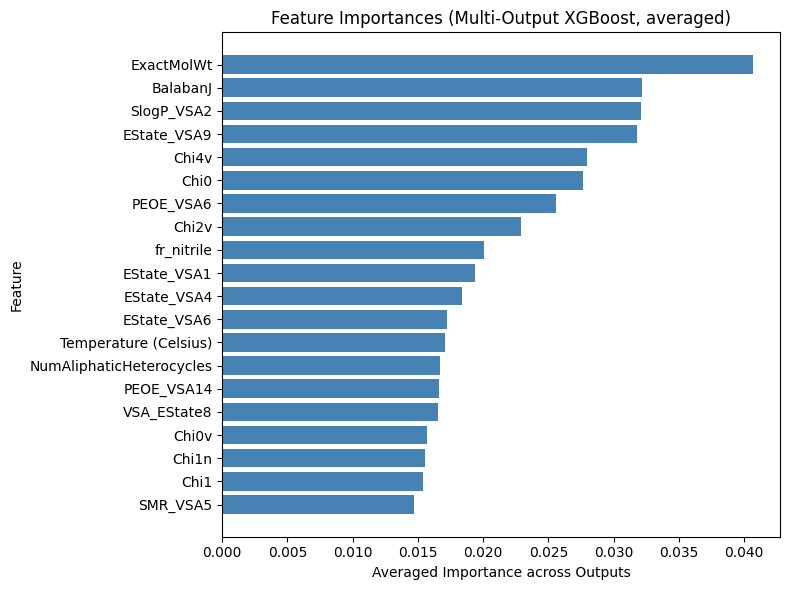

In [23]:
estimators = final_model.estimators_  # List of XGBRegressor objects
all_importances = []
for est in estimators:
    importances = est.feature_importances_
    all_importances.append(importances)

mean_importances = np.mean(all_importances, axis=0)

feature_importance_df = pd.DataFrame({
    "feature": feature_columns,
    "importance": mean_importances
}).sort_values(by="importance", ascending=False)

print(feature_importance_df.head(20))

# Plot top 20 averaged importances
top_n = 20
top_feats = feature_importance_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_feats["feature"], top_feats["importance"], color="steelblue")
plt.xlabel("Averaged Importance across Outputs")
plt.ylabel("Feature")
plt.title("Feature Importances (Multi‐Output XGBoost, averaged)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [24]:
# importances = final_model.feature_importances_  # 1D numpy array of importances
# feature_importance_df = pd.DataFrame({
#     "feature": feature_columns,
#     "importance": importances
# })

# feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

# print(feature_importance_df)

In [25]:
# # Feature importance

# save_dir1 = r"C:\Users\micha\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Current\Polystyrene-features"
# #save_dir = r"C:\Users\Dillo\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Current\Polystyrene-Polarity-Plots"
# os.makedirs(save_dir1, exist_ok=True)

# top_n = 35
# top_features = feature_importance_df.head(top_n)

# plt.figure(figsize=(8, 6))
# plt.barh(top_features["feature"], top_features["importance"], color="steelblue")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title(f"Top {top_n} Feature Importances (XGBoost)")
# plt.gca().invert_yaxis()  # so that the highest importance is at the top
# plt.tight_layout()
# save_path1 = os.path.join(save_dir1, "feature_importances2-17-25-attempt2.png")
# plt.savefig(save_path1, dpi=1200, bbox_inches="tight")
# plt.show()

In [26]:
# # ============================================================================
# # Saving polarity plots 
# # ============================================================================

# # Create a directory to save your plot (optional)
# save_dir = r"C:\Users\micha\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Current\Polystyrene-Polarity-Plots"
# #save_dir = r"C:\Users\Dillo\OneDrive\Documents\GitHub\ActiveProjectsPrivate\ActiveFiles\Scripts\PolystyreneSubset\Current\Polystyrene-Polarity-Plots"
# os.makedirs(save_dir, exist_ok=True)

# # Call the plotting function
# plot_parity_with_metrics(
#     target_name="Solvent Ratio_1",
#     data=parity_data,
#     metrics=parity_metrics,
#     save_path=os.path.join(save_dir, "solvent_ratio_parity_plot2500-2-17-25-attempt2-molecular-desc.png")
# )

In [27]:
# # Keeps track of the original solvents along with predictions:

# meta_test = meta_data.iloc[idx_test].reset_index(drop=True)

# results_test = pd.DataFrame({
#     "Solvents_1": meta_test["Solvents_1"],
#     "Solvents_2": meta_test["Solvents_2"],
#     "Observed": y_test_np_conv,
#     "Predicted": y_pred_test_np
# })

# print(results_test)

avg best error: 20.913736122080316


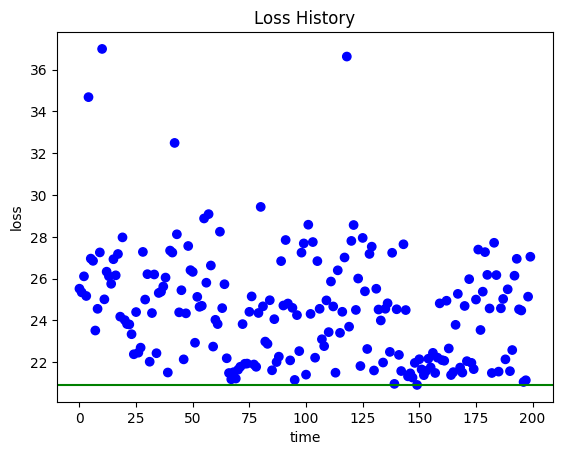

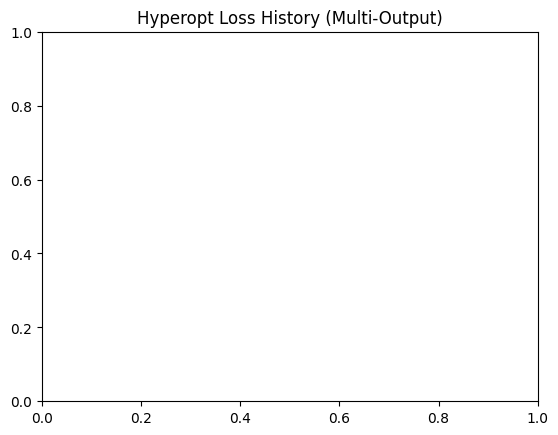

In [28]:
hyperopt.plotting.main_plot_history(trials)
plt.title("Hyperopt Loss History (Multi‐Output)")
plt.show()

Showing Histogram of 200 jobs


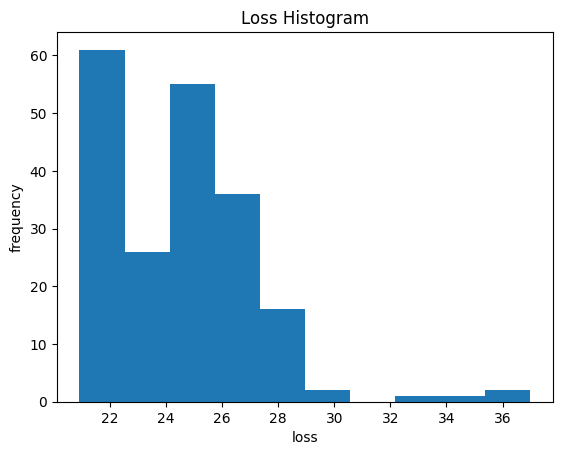

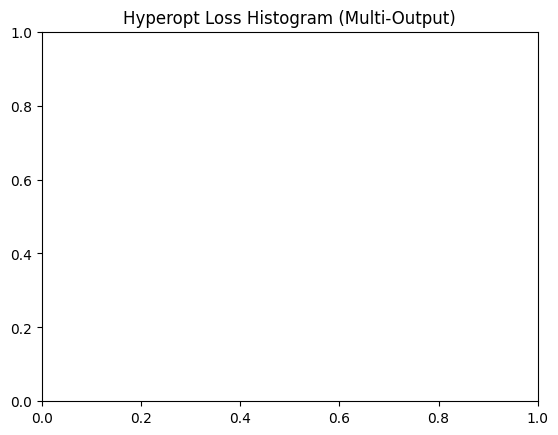

In [29]:

hyperopt.plotting.main_plot_histogram(trials)
plt.title("Hyperopt Loss Histogram (Multi‐Output)")
plt.show()

finite loss range 20.913736122080316 36.99041076445762 19.913736122080316


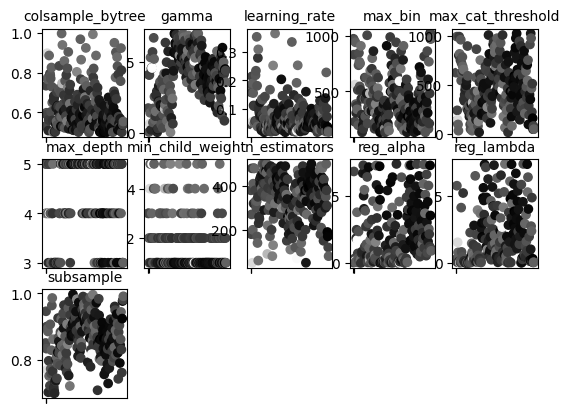

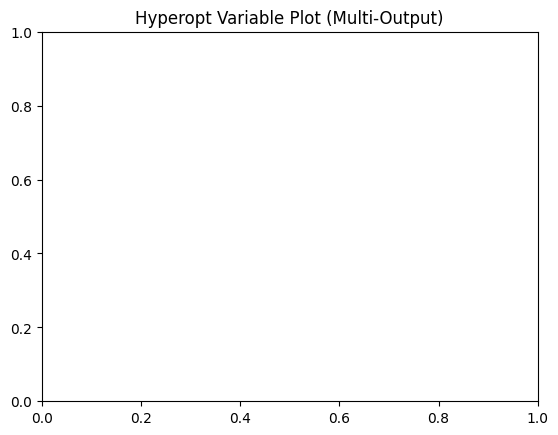

In [30]:
hyperopt.plotting.main_plot_vars(trials)
plt.title("Hyperopt Variable Plot (Multi‐Output)")
plt.show()

In [31]:


# # Plot how the loss function changed over the course of trials
# hyperopt.plotting.main_plot_history(trials)
# plt.savefig("hyperopt_history.png", dpi=1200, bbox_inches="tight")
# plt.show()

# # Plot a histogram of the loss
# hyperopt.plotting.main_plot_histogram(trials)
# plt.savefig("hyperopt_histogram.png", dpi=1200, bbox_inches="tight")
# plt.show()

# # Plot a summary of the variables that Hyperopt searched
# hyperopt.plotting.main_plot_vars(trials)
# plt.savefig("hyperopt_vars.png", dpi=1200, bbox_inches="tight")
# plt.show()